In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

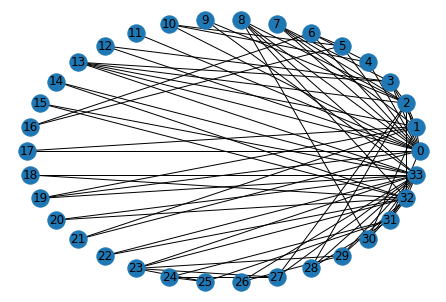

In [ ]:
G = nx.karate_club_graph()
nx.draw_circular(G, with_labels=True)
plt.show()

In [ ]:
def get_percolated_cliques(G, k):
    cliques = list(frozenset(c) for c in nx.find_cliques(G) if len(c) >= k)

    # First index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    # For each clique, see which adjacent cliques percolate
    perc_graph = nx.Graph()
    for clique in cliques:
        for adj_clique in get_adjacent_cliques(clique, membership_dict):
            if len(clique.intersection(adj_clique)) >= (k - 1):
                perc_graph.add_edge(clique, adj_clique)

    # Connected components of clique graph with perc edges
    # are the percolated cliques
    iterables = nx.connected_components(perc_graph)
    res = map(lambda component: frozenset.union(*component), iterables)
    df = pd.DataFrame(res)

    return df

def get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    for n in clique:
        for adj_clique in membership_dict[n]:
            if clique != adj_clique:
                adjacent_cliques.add(adj_clique)
    return adjacent_cliques

In [ ]:
a = get_percolated_cliques(G, 3)

In [ ]:
a

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,1,2,3,7,8,12.0,13.0,14.0,15.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
1,0,16,4,5,6,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
clusters = {} 
for node in G.nodes:
  for i in np.arange(df.shape[0])
    clusters[node] = {}
    if any(df.iloc[i,:] == node):
      


SyntaxError: ignored